In [1]:
using Pkg
Pkg.activate(".")

In [3]:
using Revise
using DeconvOptim, TestImages, ImageShow, Plots, LinearAlgebra, IndexFunArrays, Noise
using FourierTools, SpecialFunctions, FFTW, Images, Tullio, PGFPlotsX
using Statistics, StatsBase

┌ Info: Precompiling PGFPlotsX [8314cec4-20b6-5062-9cdb-752b83310925]
└ @ Base loading.jl:1317
┌ Info: Precompiling Contour [d38c429a-6771-53c6-b99e-75d170b6e991]
└ @ Base loading.jl:1317


In [6]:
img = Float32.(testimage("resolution_test_512"));

In [7]:
radius = 51.2
f_max = 51.2 / size(img, 1) * 2
psf = Float32.(DeconvOptim.generate_psf(size(img), radius));

In [8]:
img_n = Float32.(poisson(DeconvOptim.conv(img, psf), 100));

In [9]:
reg = DeconvOptim.GR(ϵ=1f-8)
#reg = TV();

In [10]:
iter=50

λ = 0.03

ncc_log_no_reg = Float32[]
ncc_log_reg = Float32[]
ncc_log_reg_strong = Float32[]

debug_no_reg(rec) = push!(ncc_log_no_reg, DeconvOptim.normalized_cross_correlation(img, rec))
debug_reg(rec) = push!(ncc_log_reg, DeconvOptim.normalized_cross_correlation(img, rec))
debug_reg_strong(rec) = push!(ncc_log_reg_strong, DeconvOptim.normalized_cross_correlation(img, rec))

img_deconv_reg, r = deconvolution(img_n, psf, regularizer=reg, iterations=iter, λ=λ, debug_f=debug_reg);
@show r
img_deconv_reg_strong, r = deconvolution(img_n, psf, regularizer=reg, iterations=iter, λ=0.5,  debug_f=debug_reg_strong);
@show r
img_deconv_nothing, r = deconvolution(img_n, psf, regularizer=nothing, iterations=iter, λ=λ,  debug_f=debug_no_reg);
@show r

0;

# remove duplicates to get the values after each iterations
filter_dup(x) = rle(x)[1]
#ncc_log_no_reg = filter_dup(ncc_log_no_reg)
#ncc_log_reg = filter_dup(ncc_log_reg)
#ncc_log_reg_strong = filter_dup(ncc_log_reg_strong)


r =  * Status: success

 * Candidate solution
    Final objective value:     -3.707648e+04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 7.45e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.89e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.60e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    24
    f(x) calls:    51
    ∇f(x) calls:   25

r =  * Status: success

 * Candidate solution
    Final objective value:     -3.179400e+04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.54e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.17e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.24e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    36
    f(x

filter_dup (generic function with 1 method)

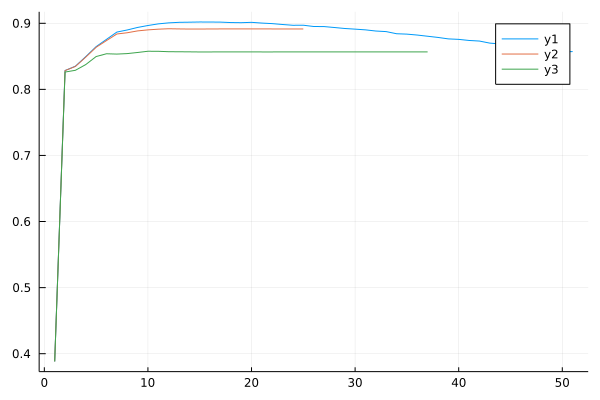

In [11]:
plot(ncc_log_no_reg)
plot!(ncc_log_reg)
plot!(ncc_log_reg_strong)

In [12]:
#save("../../paper/figures/fabio_blurry.png", img_blurry ./ maximum(img_blurry))
#save("../../paper/figures/fabio_deconv_regularizer_005_iter_30.png", min.(1.0, img_deconv_reg))
#save("../../paper/figures/fabio_deconv_no_reg_iter_30.png", img_deconv_nothing ./ maximum(img_deconv_nothing))

save("../../paper/figures/resolution_test_chart_blurry.png", min.(1, img_blurry))
save("../../paper/figures/resolution_test_chart_regularizer_005_iter_30.png", min.(1.0, img_deconv_reg))
save("../../paper/figures/resolution_test_chart_no_reg_iter_30.png", min.(1.0, img_deconv_nothing))

LoadError: UndefVarError: img_blurry not defined

┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1317


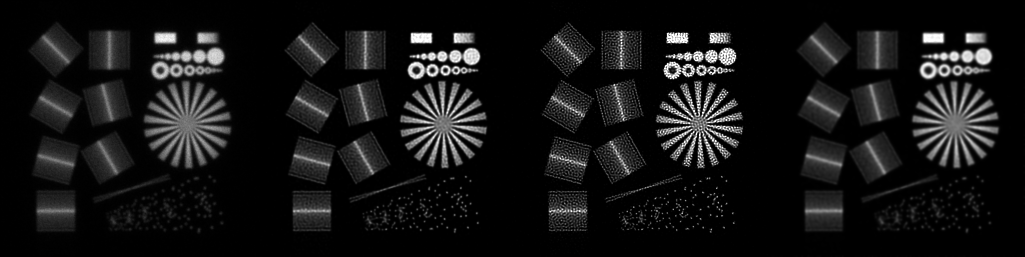

In [13]:
[Gray.(img_n) Gray.(img_deconv_reg) Gray.(img_deconv_nothing) Gray.(img_deconv_reg_strong)] 

In [14]:
f, G_R_reg = DeconvOptim.relative_energy_regain(img, img_deconv_reg)
f, G_R_reg_strong = DeconvOptim.relative_energy_regain(img, img_deconv_reg_strong)
f, G_R_nothing = DeconvOptim.relative_energy_regain(img, img_deconv_nothing)
f, G_R_n = DeconvOptim.relative_energy_regain(img, img_n);

f_rel = f ./ f_max;

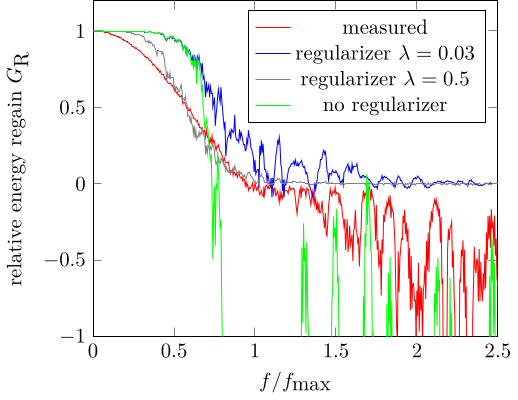

In [15]:
plt1 = @pgf PGFPlotsX.Axis(
    {xlabel="\$f/f_{\\textrm{max}} \$", ylabel="relative energy regain \$G_{\\textrm{R}}\$",
        xmin=0, xmax=2.5, ymin=-1, ymax=1.2, 
        legend_pos="north east", legend_entries={"measured", "regularizer \$\\lambda=0.03\$",  "regularizer \$\\lambda=0.5\$", "no regularizer"}},
    
    Plot({"sharp plot", color="red"
        },
        Table([f_rel, G_R_n])
    ),
    Plot({"sharp plot", color="blue"
        },
        Table([f_rel,  G_R_reg])
    ),
    
    Plot({"sharp plot", color="gray"
        },
        Table([f_rel,  G_R_reg_strong])
    ),

    Plot({"sharp plot", line_width="0.01cm", color="green"
        },
    Table([f_rel, max.(-10, G_R_nothing)])
    ),
)
pgfsave("../../paper/figures/test_chart_relative_energy_regain.pdf", plt1)
plt1

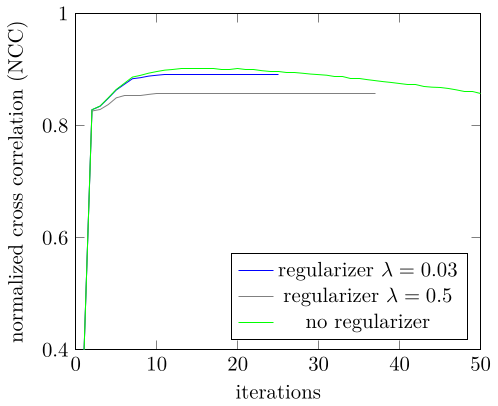

In [16]:
plt2 = @pgf PGFPlotsX.Axis(
    {xlabel="iterations", ylabel="normalized cross correlation (NCC)",
        xmin=0, xmax=50, ymin=0.4, ymax=1.0, 
        legend_pos="south east", legend_entries={"regularizer \$\\lambda=0.03\$",  "regularizer \$\\lambda=0.5\$", "no regularizer"}},
    
    Plot({"sharp plot", color="blue"
        },
        Table([1:length(ncc_log_reg), ncc_log_reg])
    ),
    Plot({"sharp plot", color="gray"
        },
        Table([1:length(ncc_log_reg_strong), ncc_log_reg_strong])
    ),
    
    Plot({"sharp plot", color="green"
        },
        Table([1:length(ncc_log_no_reg), ncc_log_no_reg])
    ),

)
pgfsave("../../paper/figures/test_chart_ncc.pdf", plt2)
plt2